***Authors: Jarod Carroll, Sam Thurman, Calvin Tirrell***\
***Date: 3/6/2020***

# **Multiple Regression Analysis of Housing Sale Prices in 2019**

**Data Source: https://info.kingcounty.gov/assessor/DataDownload/default.aspx**

## Methodology
1. Data Acquisition
    * Get Property sales and assesments from the King County Department of Asssesments website
    * Merge the Sale information with the house information
    * Save the Merged table to the repo
2. Data Cleaning
    * 
    * 
3. Creation of a model
    * Start with a base linear regression model
    * Expand on model to include more explanatory variables
4. Analysis of Model
    * Use metrics to find the best model

#### Import Necessary Packages

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.make_data_table import *
from src.stat_helpers import *
from src.stats_maker import *
from src.wrangle_helpers import *

## Data Acquisition
This will get the data from the internet, unzip the files, only get the 2019 data, merge the files then saves it to the repo as well as deleting the downloaded files.\
It has already been run and is save to the repo under the data folder.

In [3]:
#build_data_file()

New files downloaded: {'EXTR_Parcel.csv', 'EXTR_ResBldg.csv', 'EXTR_RPSale.csv'}
PINs added to tables
Tables merged and saved to: /Users/jarodc33/Mod_Projects/mod_2/king_county_housing/data/housing2019.csv
All downloaded files have been deleted.
Data is now accessible from the data folder.


## Data Cleaning

The load and wrangle function will obtain the data and will add some extra columns.\
The modified dataframe makes certain columns into integers and has added columns that are useful for analysis.


In [3]:
data = load_and_wrangle_data('../../data/housing2019.csv')[1]

## Creation of a Model
#### Base Model

First in order to make a base model we started by looking at a correlation heatmap of variable compared to Sale Price. Then we chose to use the SqFtTotLiving as a comparison for our first regression model.

We then wanted to first plot this relationship to see if it seems at all slightly linear.

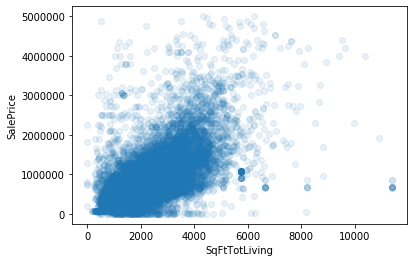

In [4]:
plt.scatter(data['SqFtTotLiving'], data['SalePrice'], alpha = 0.1)
plt.xlabel('SqFtTotLiving')
plt.ylabel('SalePrice');

It looks as though there is a correlation so we will run a linear regression on these two variables.

In [5]:
base_model = get_model(data, ['SqFtTotLiving'], dependent = 'SalePrice')
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.547e+04
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:47:58   Log-Likelihood:            -4.2558e+05
No. Observations:               29621   AIC:                         8.512e+05
Df Residuals:                   29619   BIC:                         8.512e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       1.24e+05   5818.374     21.317      0.000    1.13e+05    1.35e+05
SqFtTotLiving   303.8229      2.443    124.375      0.000     299.035     308.611
==============================================================================
Omnibus:                    15543.448   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229982.402
Skew:                           2.184   Prob(JB):                         0.00
Kurtosis:                      15.933   Cond. No.                     5.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There is an R-squared of about 0.34. Our p values for the intercept and coefficients are low enough to say that theyt are statistically significant.
It shows that for each square foot off living space the sale price is expected to go up $304

#### Evaluation of Model

We used 4 measures to validate each model:
1. Rainbow Statistic: This tests if the independant variable linearly predict the dependant (Lower statistic or higher p-value  is better)
2. Jarque-Bera (JB): Tells whether the residuals are normally distributed (Lower statistic or higher p-value is better)
3. Homoscedasticity: Indicates if the variances are homogeneous (Higher p-value is better)
4. Variance Inflation Factor: Measures multicollinearity. Lower VIF indicated the independant variables do not correlate with eachother

In order to generate this we use a method in stats_maker
The JB can be found in the model Summary

In [6]:
stats = stats_from_columns(data, ['SqFtTotLiving'], dependent = 'SalePrice')
print('Rainbow p-value: ' + str(stats['rainbow']['p-value']))
print('JB: 229982')
print('Homoscedasticity F-statistic: 15470')

Rainbow p-value: 0.013161169064821551
JB: 229982
Homoscedasticity F-statistic: 15470


Currently our model violates all of our measure's assumptions. 

We can also visualize the residuals to get an idea of what they look like. We take te logarithm because the non-logarithm residuals do not give a good sense of their distribution

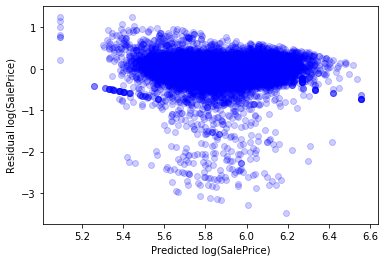

In [7]:
log_df = data.copy()
log_df['SalePrice'] = log_df['SalePrice']

y = log_df['SalePrice'].apply(lambda x: math.log(x, 10))
y_hat = pd.Series(get_model(log_df, ['SqFtTotLiving']).predict()).apply(lambda x: math.log(x, 10))
plt.scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2)
plt.xlabel('Predicted log(SalePrice)')
plt.ylabel('Residual log(SalePrice)');

As we can see our model is greatly over predicting saleprice at 10<sup>5.6</sup> to 10<sup>6</sup>

## Obtaining our Best model

In order to improve our model more independant variables were added to the relationship.

SqFtTotLiving was replaced with BldgGrade because it BldgGrade was more predictive and also reduced the collinearity between variables. They could not be included together because their collinearity was above our VIF threshold of 5 when used together.

A list of columns were used to generate our current best model as seen bellow.

In [8]:
columns = ['BldgGrade', 'TidelandShoreland', 'SqFtOpenPorch', 'SqFtDeck', 'Area', 'ViewScore','YrRenovated']
best_model_stats = stats_from_columns(data, columns, dependent = 'SalePrice')
best_model_stats['ols'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     3258.
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:47:59   Log-Likelihood:            -4.2335e+05
No. Observations:               29621   AIC:                         8.467e+05
Df Residuals:                   29613   BIC:                         8.468e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -9.965e+05   1.61e+04    -61.859      0.000   -1.03e+06   -9.65e+05
BldgGrade          2.277e+05   2099.565    108.471      0.000    2.24e+05    2.32e+05
TidelandShoreland  3.875e+05   2.83e+04     13.680      0.000    3.32e+05    4.43e+05
SqFtOpenPorch       438.7000     16.503     26.583      0.000     406.353     471.047
SqFtDeck            100.7689     11.222      8.979      0.000      78.772     122.765
Area              -1053.7044     84.901    -12.411      0.000   -1220.114    -887.295
ViewScore          1.949e+05   4641.970     41.995      0.000    1.86e+05    2.04e+05
YrRenovated         109.7593      5.509     19.924      0.000      98.961     120.557
==============================================================================
Omnibus:                    16269.937   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           283186.578
Skew:                           2.267   Prob(JB):                         0.00
Kurtosis:                      17.453   Cond. No.                     5.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
print('Rainbow p-value: ' + str(best_model_stats['rainbow']['p-value']))
print('JB: 283186')
print('Homoscedasticity statistic: 3258')
best_model_stats['vif']

Rainbow p-value: 0.35401682824193115
JB: 283186
Homoscedasticity statistic: 3258


,VIF,feature
0,4.986103,BldgGrade
1,1.087816,TidelandShoreland
2,1.364496,SqFtOpenPorch
3,1.495454,SqFtDeck
4,4.078935,Area
5,1.149844,ViewScore
6,1.058398,YrRenovated


The R-squared of our model increased to 0.44, which is an improvement from the original model and previous nmodels. The Rainbow p-value has increased and it no longer violates the assumption or linearity. The JB however has increased but the Homoscedasticity F-statistic has greatly decreased! The variance inflation factor between the variable in under 5 and there for we can say that the multicolinearity between the variables is not high.

The residuales were once again plotted in order to visualize.

Logarithms were applied as before in order to visualize.

Negative values in y hat leads to failure of the logarithm. Taking the logarithm before leads to a graph of a similar shape so that is what I will use. \
I am doing this because we just want an idea of the shape.

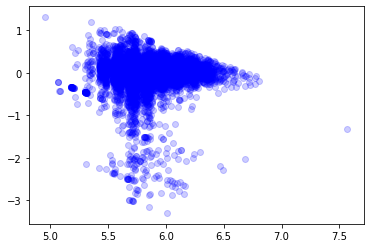

In [10]:
log_df = data.copy()
log_df['SalePrice'] = log_df['SalePrice'].apply(lambda x: math.log(x, 10))

y = log_df['SalePrice']
y_hat = pd.Series(get_model(log_df, columns).predict())
plt.scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2)

We can see our model is greatly over predicting saleprice at 10<sup>5.5</sup> to 10<sup>6</sup>